# Discretization
Here we will describe *Invert4Geom's* approach to discretization. Discretization refers to the process of transforming something of continuous-value (smoothly varying) into a discrete form. For example, a Digital Elevation Model (DEM) is a discretized representation of the elevation of a landscape. Each grid cell of the DEM has a discrete value.

In *Invert4Geom* we are interested in modeling the geometry (i.e. relief, topography) of some geologic layer. This maybe to the geometry of the Earth's surface (referred to as topography), the geometry of the Moho, or many other examples.

To do this, we must treat these geologic layers as density contrasts, separating materials of differing densities. For example, the Moho is the density contrast between the Earth's crust and mantle, or the Earth's surface, is terrestrial regions, is the density contrast between air and rock. 

To discretize these density contrasts, we use a layer of adjacent, vertical, right-rectangular prisms, each assigned a density contrast value. This notebook walks you though how this discretization is achieved, using a synthetic dataset of topography. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2


import logging

import xarray as xr
from polartoolkit import maps

from invert4geom import plotting, synthetic, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Create some topography data
`Invert4Geom` uses the Python package `xarray` for handing gridded data. The format for this gridded data are `DataArrays`, which have two coordinates (by convention we use the names `easting` and `northing`), and one variable, which for topography is the elevation (use the name `upward`). `DataArrays` can also include helpful metadata such as units and the data source.

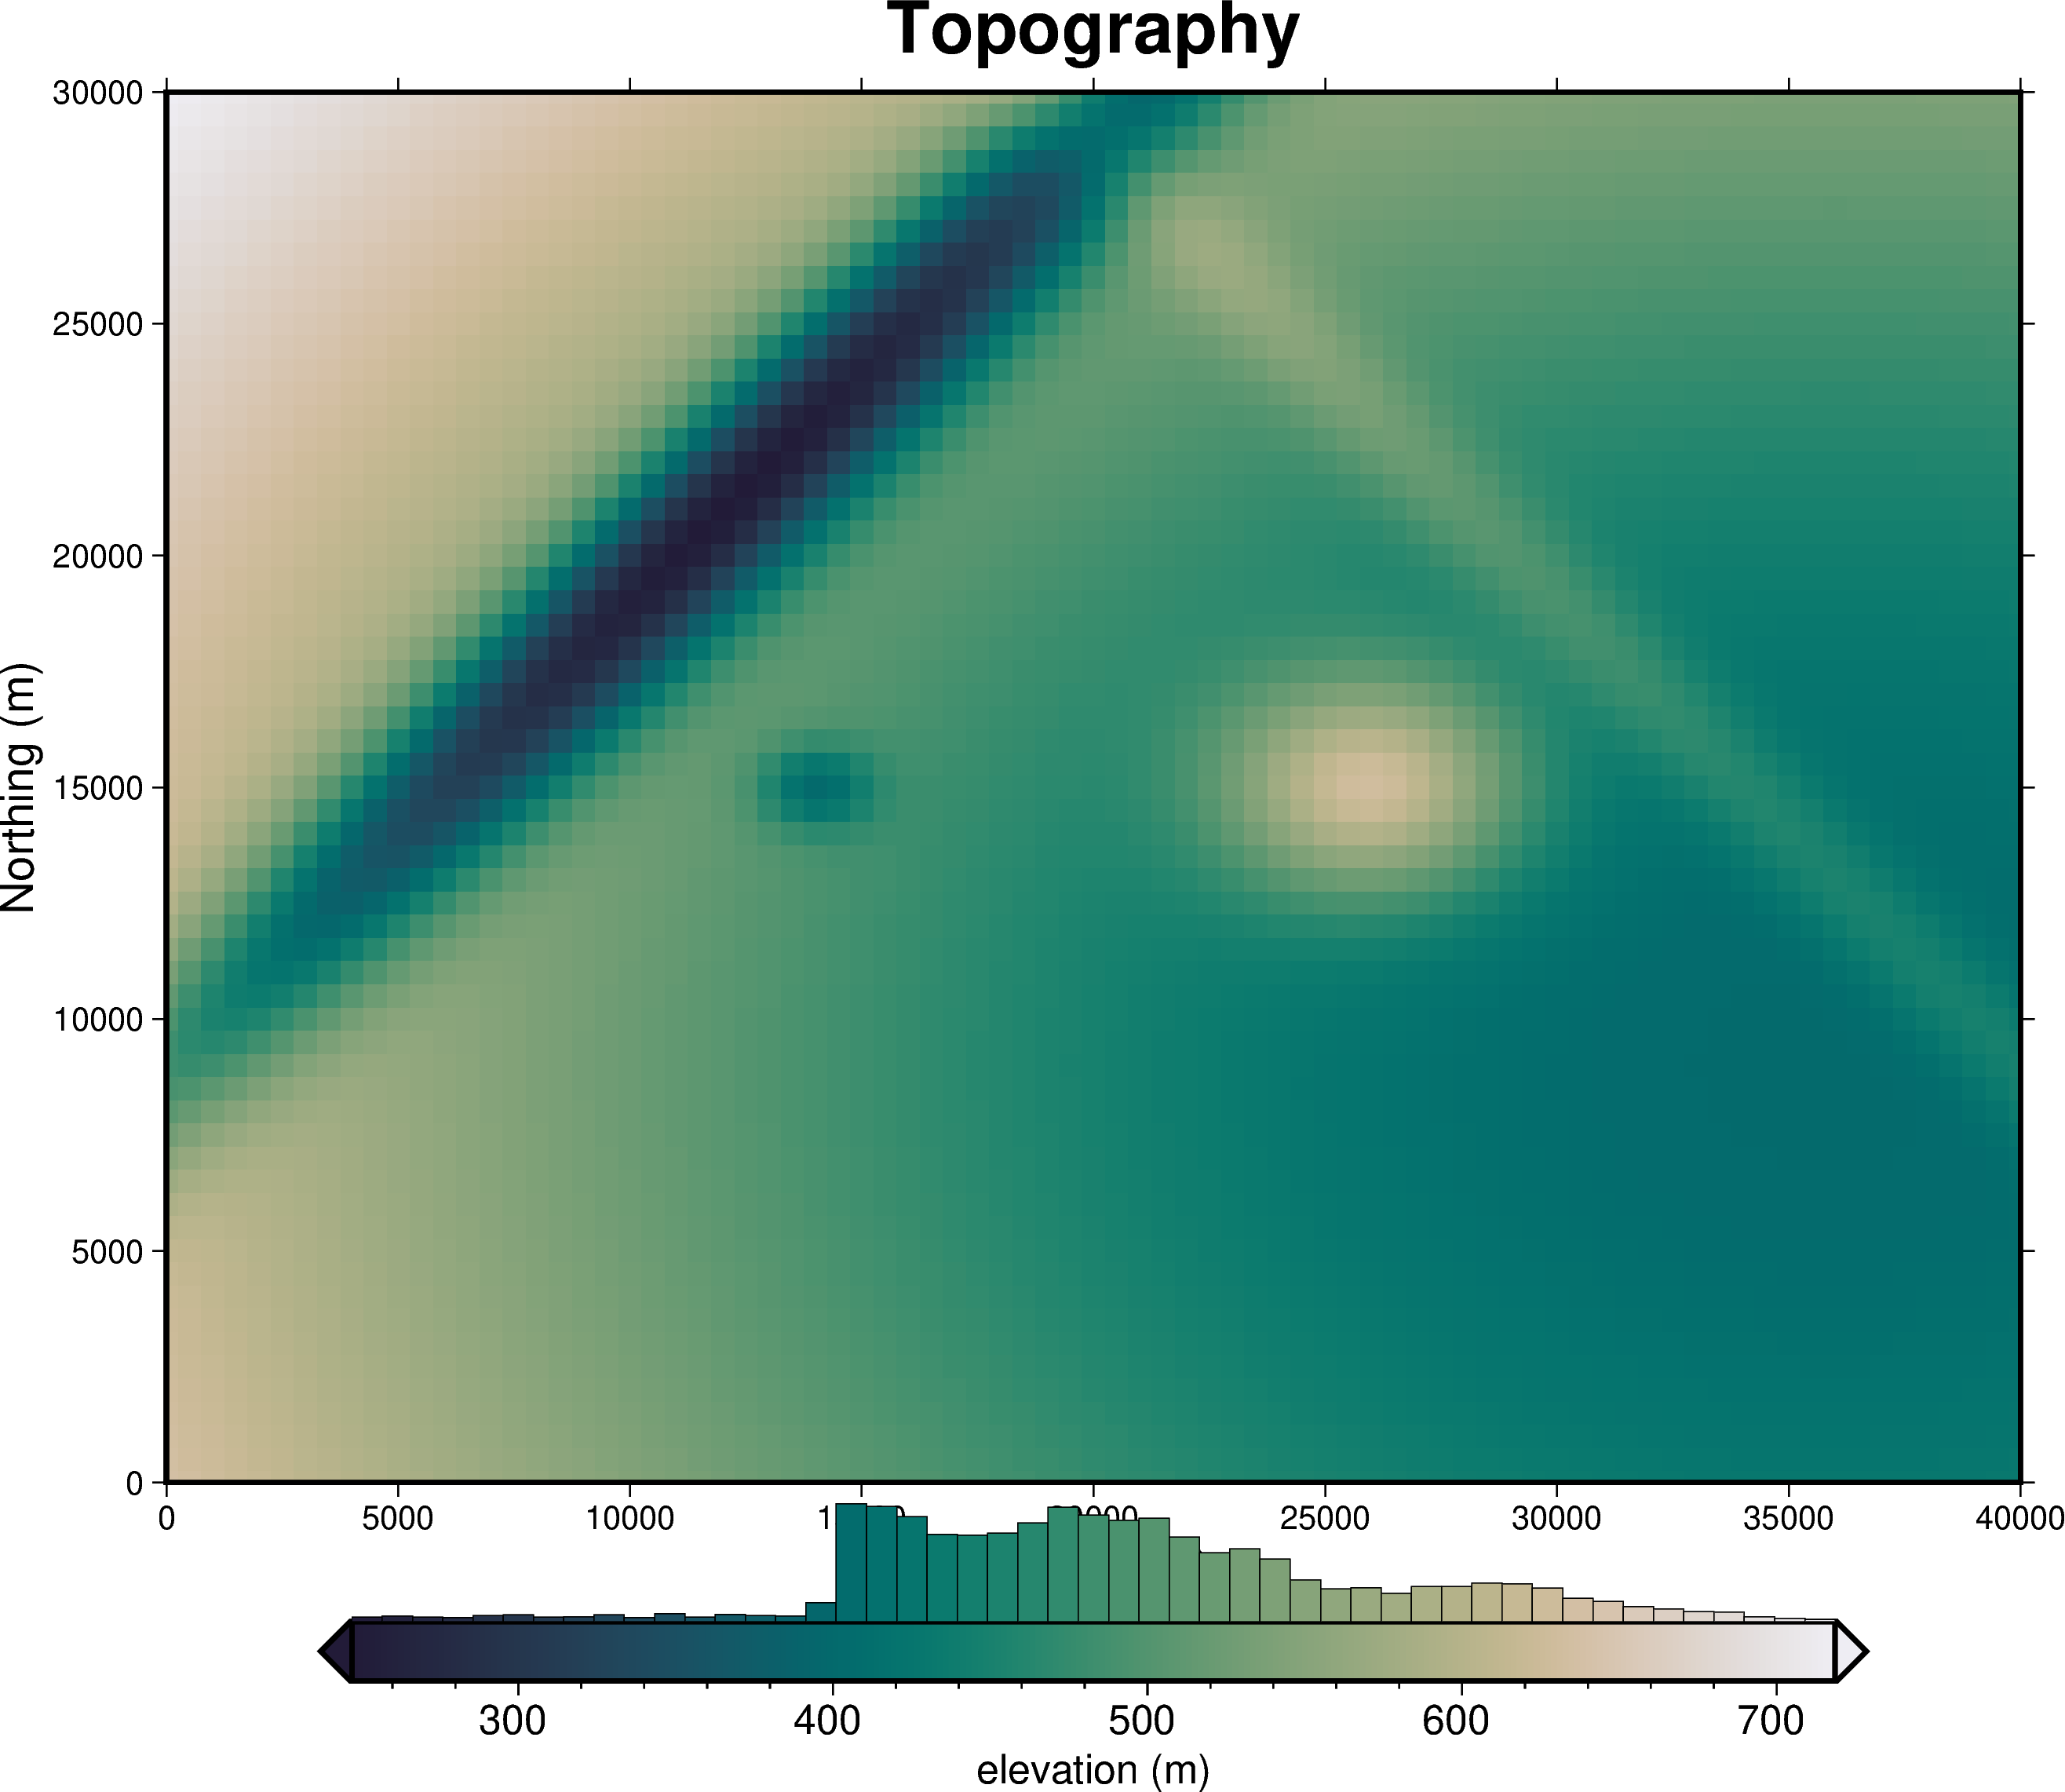

<xarray.DataArray 'upward' (northing: 61, easting: 81)> Size: 40kB
array([[637.12943453, 632.19538446, 627.28784729, ..., 429.33158321,
        429.94283295, 430.64751872],
       [634.98693024, 630.03468543, 625.10864111, ..., 426.39921792,
        427.01279345, 427.72016051],
       [632.95724141, 627.98926162, 623.04617819, ..., 423.6241977 ,
        424.23997422, 424.94987872],
       ...,
       [709.90739328, 705.61112993, 701.33808009, ..., 528.97704204,
        529.50925875, 530.12283044],
       [714.19597392, 709.93730524, 705.70164695, ..., 534.84886306,
        535.37642258, 535.98462518],
       [718.55151946, 714.33103249, 710.13334959, ..., 540.8123708 ,
        541.33520041, 541.93795008]])
Coordinates:
  * easting   (easting) float64 648B 0.0 500.0 1e+03 ... 3.9e+04 3.95e+04 4e+04
  * northing  (northing) float64 488B 0.0 500.0 1e+03 ... 2.9e+04 2.95e+04 3e+04

In [2]:
# set grid parameters
spacing = 500
region = [0, 40000, 0, 30000]

# create synthetic topography data
topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_grd(
    topography,
    title="Topography",
    cmap="rain",
    reverse_cpt=True,
    hist=True,
    cbar_yoffset=1.5,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000+lEasting (m)", "yaf10000+lNorthing (m)"],
)
fig.show()

topography

## Discretize the topography as a prism layer

This will convert each topographic grid cell into the a vertical prism. Each of these prisms is define by a top and a bottom. 

Each prism is created between the grid cell's elevation and the elevation of a chosen reference level, `zref`. This means some prisms are above `zref` and other are below.

Here we set `zref` to be the mean elevation of the grid. 

In this example, our topography represents the surface of the earth, which can be thought of as the density contrast between `air` (~1 kg/m³) and `rock` (~2670 kg/m³). Each prism is assigned this density contrast value (2670 kg/m³ - 1 kg/m³), but prisms above the `zref` are assigned a positive density contrast (+2669 kg/m³) and prisms below `zref` are assigned a negative density contrast (-2669 kg/m³). 

Under the hood, the function `grids_to_prism` uses the Python package `Harmonica` to create a layer of prisms. 

In [3]:
# the density contrast is between rock (~2670 kg/m³) and air (~1 kg/m³)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    topography,
    zref,
    density=density_grid,
)
prisms

<xarray.Dataset> Size: 159kB
Dimensions:    (northing: 61, easting: 81)
Coordinates:
  * easting    (easting) float64 648B 0.0 500.0 1e+03 ... 3.9e+04 3.95e+04 4e+04
  * northing   (northing) float64 488B 0.0 500.0 1e+03 ... 2.95e+04 3e+04
    top        (northing, easting) float64 40kB 637.1 632.2 ... 541.3 541.9
    bottom     (northing, easting) float64 40kB 490.9 490.9 ... 490.9 490.9
Data variables:
    density    (northing, easting) int64 40kB 2669 2669 2669 ... 2669 2669 2669
    thickness  (northing, easting) float64 40kB 146.2 141.3 136.4 ... 50.4 51.0
Attributes:
    coords_units:      meters
    properties_units:  SI
    zref:              490.93632804524606

### The below figure colors each prism by the value of its thickness.

Notice that purple prisms show where the original topographic elevation was close the the `zref` value.

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


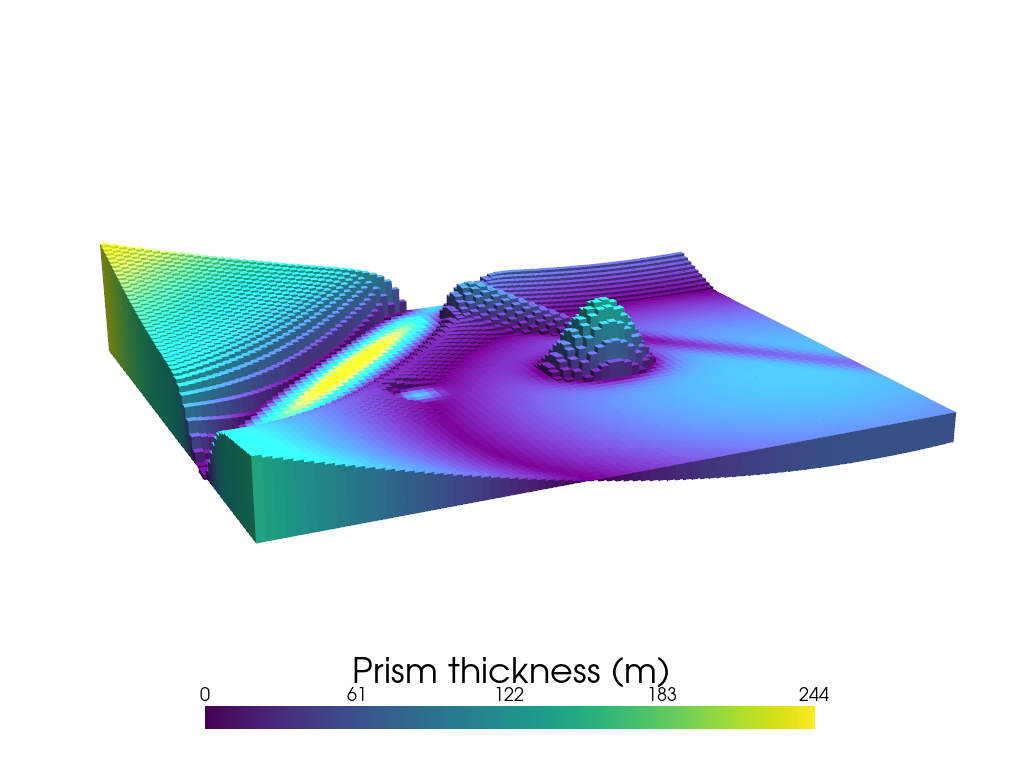

In [4]:
plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Prism thickness (m)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

### The below figure instead colors each prism by its assigned density contrast value.

Notice that there are only two density contrast options, positive (yellow) and negative (purple).

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


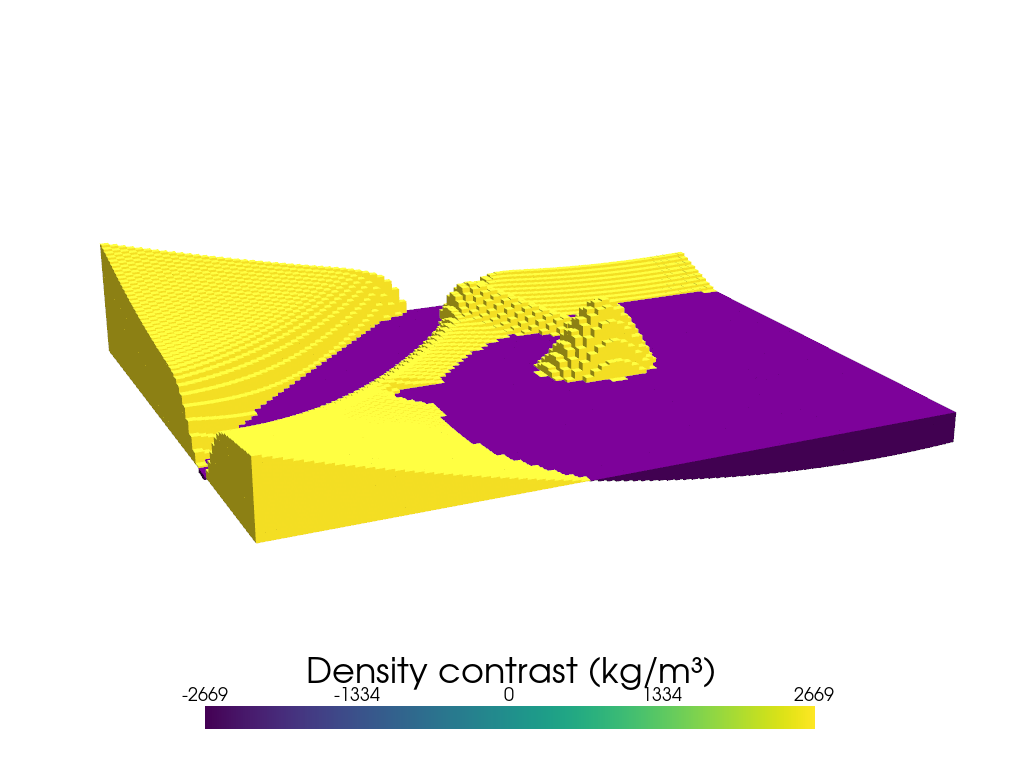

In [5]:
plotting.show_prism_layers(
    prisms,
    color_by="density",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Density contrast (kg/m³)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

### Changing zref

Below we show what a zref outside the range of the topography data does.

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


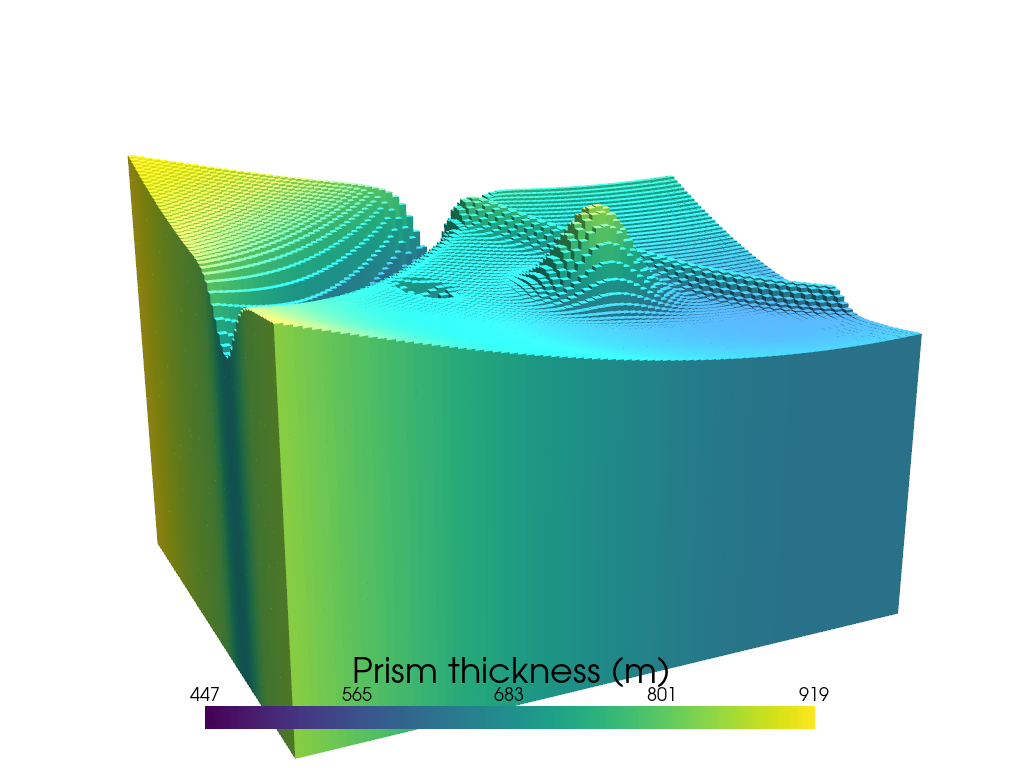

In [6]:
zref = -200

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    topography,
    zref,
    density=density_grid,
)
prisms
plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    log_scale=False,
    zscale=30,
    backend="static",
    show_axes=False,
    scalar_bar_args={
        "title": "Prism thickness (m)",
        "title_font_size": 35,
        "fmt": "%.0f",
        "width": 0.6,
        "position_x": 0.2,
    },
)

See user guide [variable density contrast](variable_density_contrast.ipynb) for an example of how to incorparate spatially-variable density contrast values.